In [1]:
###### 

In [2]:
# Ref:

# Blog post
# Part1: Mask-RCNN
# https://haochen23.github.io/2020/06/fine-tune-mask-rcnn-pytorch.html#.Y-2Wt-xBzUK

# Part 2: Faster-RCNN Beagle Detector
# https://haochen23.github.io/2020/06/fine-tune-faster-rcnn-pytorch.html#.Y-8k_OxBzUK

# Video by DigitalSreeni
# https://www.youtube.com/watch?v=NEl9RPyMgzY&t=28s

# TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

# Beagle Detector: Fine-tune Faster-RCNN
# https://haochen23.github.io/2020/06/fine-tune-faster-rcnn-pytorch.html#.Y-2VjexBzUI

In [3]:
import pandas as pd
import numpy as np
import os

import cv2

import ast

import torch
import torchvision.transforms as T
import torchvision

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch.utils.data
from PIL import Image

from tqdm import tqdm

import matplotlib.pyplot as plt

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Note: Pytorch uses a channels-first format:
# [batch_size, num_channels, height, width]

print(torch.__version__)
print(torchvision.__version__)

1.12.0
0.13.0


In [4]:
# Set the seed values

import random

# Set the seed value all over the place to make this reproducible.
seed_val = 101

os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True

In [5]:
data_path = '../input/exp77-tb-add-lung-boxes-to-detection-folds/df_data_w_lung_boxes.csv'

model_path_0 = '../input/exp103-tb-exp96-w-aug/model.pt'


In [6]:
os.listdir('../input/')

['vindr-comp-proc-images',
 'pneumonia-comp-proc-images',
 'covid-comp-proc-images',
 'exp77-tb-add-lung-boxes-to-detection-folds',
 'tbx11k-simplified',
 'exp103-tb-exp96-w-aug']

## Config

In [7]:
CLASS_LIST = CLASS_NAMES = ['normal','opacity']

CHOSEN_FOLD = 0

THRESHOLD = 0.5

#NUM_FOLDS = 5

NUM_EPOCHS = 10

TRAIN_BATCH_SIZE = 5
VAL_BATCH_SIZE = 1


NUM_CORES = os.cpu_count()
NUM_CORES

2

## Define the device

In [8]:
# For GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

if torch.cuda.is_available():
    print('Num GPUs:', torch.cuda.device_count())
    print('GPU Type:', torch.cuda.get_device_name(0))

cuda:0
Num GPUs: 1
GPU Type: Tesla P100-PCIE-16GB


## Load the data

In [9]:
df_data = pd.read_csv(data_path)

print(df_data.shape)

df_data.head(2)

(60109, 9)


,fname,image_height,image_width,bbox,target,data_source,label,path,fold
0,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 264, 'ymin': 152, 'width': 213, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0
1,00436515-870c-4b36-a041-de91049b9ab4.png,1024,1024,"{'xmin': 562, 'ymin': 152, 'width': 256, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,3.0


In [10]:
df_data['target'].value_counts()

3    25869
1    19724
0    14516
Name: target, dtype: int64

## Remove the vindr_pcxr data

In [11]:
df_data['data_source'].value_counts()

pneu_comp     33265
covid_comp    12198
vindr_comp     6665
tbx11k         5010
vindr_pcxr     2971
Name: data_source, dtype: int64

In [12]:
df_data = df_data[df_data['data_source'] != 'vindr_pcxr']

df_data = df_data.reset_index(drop=True)

df_data['data_source'].value_counts()

pneu_comp     33265
covid_comp    12198
vindr_comp     6665
tbx11k         5010
Name: data_source, dtype: int64

## Load one image

(1024, 1024)


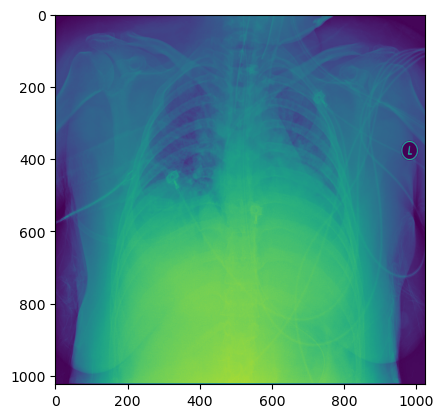

In [13]:
i = 0
path = df_data.loc[i, 'path']
image = plt.imread(path)

print(image.shape)

plt.imshow(image)

## Helper functions

In [14]:
# Confusion matrix where the size of the plot and the text size can be changed

# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                         text_size=12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=text_size)
    plt.yticks(tick_marks, classes, fontsize=text_size)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=text_size)

    plt.ylabel('True label', fontsize=text_size)
    plt.xlabel('Predicted label', fontsize=text_size)
    plt.tight_layout()

In [15]:
def display_images(df):
    
    """
    Display jpg images in a grid.
    """
    
    plt.style.use("default")
    plt.figure(figsize=(13,12))

    rows = 5
    cols = 6

    for i in range(rows*cols):

        path = df.loc[i, 'path']
        label = df.loc[i, 'label']
        
        image = plt.imread(path)

        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.title(label, color="black", fontsize=12)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [16]:
def display_images_from_batch(images):
    
    """
    Display torch tensor images from the dataloader.
    """
    
    #images = data['images']
    #targets = data['targets']
    
    plt.style.use("default")
    plt.figure(figsize=(13,12))

    rows = 1
    cols = 3

    for i in range(rows*cols):

        image = images[i]
        #label = targets[i]

        # convert from (C, H, W) to (H, W, C) format
        image = image.permute((1, 2, 0))

        # select the first channel only
        image = image[:, :, 0]

        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        #plt.title(label, color="black", fontsize=12)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [17]:
def draw_pred_bbox_on_image(image, coords_list):
    
    """
    Input:
    image: type numpy array
    coords_list: type list with format: [xmin, ymin, xmax, ymax]
    
    Output:
    image: The bbox is drawn on it.
    
    """

    xmin = int(coords_list[0])
    ymin = int(coords_list[1])
    xmax = int(coords_list[2])
    ymax = int(coords_list[3])

     # Draw the bbox on the image
    start_point = (xmin, ymin) 
    end_point = (xmax, ymax) 
    #bbox_color = (255, 255, 0)  # yellow
    bbox_color = (255, 0, 255)
    bbox_thickness = 10

    image = cv2.rectangle(image, start_point, end_point, 
                          bbox_color, bbox_thickness)
    
    return image

In [18]:
# Draw a bbox on an image

def draw_true_bbox_on_image(image, coords_dict):
    
    if coords_dict != 'none':

        coords_dict = ast.literal_eval(coords_dict)

        xmin = int(coords_dict['xmin'])
        ymin = int(coords_dict['ymin'])
        width = int(coords_dict['width'])
        height = int(coords_dict['height'])

        xmax = xmin + width
        ymax = ymin + height

         # Draw the bbox on the image
        start_point = (xmin, ymin) 
        end_point = (xmax, ymax) 
        bbox_color = (255, 255, 255)  # white
        bbox_thickness = 10

        image = cv2.rectangle(image, start_point, end_point, 
                              bbox_color, bbox_thickness)
    
    return image

In [19]:
def draw_mask_on_image(image, bool_mask):
    
    # Define a function that outputs a mask with a random colour
    def get_coloured_mask(mask):
    
        """
        Source: https://haochen23.github.io/2020/06/fine-tune-mask-rcnn-pytorch.html#.Y-3RVOxBzUL

        random_colour_masks

        """

        colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
        r = np.zeros_like(mask).astype(np.uint8)
        g = np.zeros_like(mask).astype(np.uint8)
        b = np.zeros_like(mask).astype(np.uint8)

        r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]

        coloured_mask = np.stack([r, g, b], axis=2)

        return coloured_mask


    rgb_mask = get_coloured_mask(bool_mask)
    image = cv2.addWeighted(image, 1, rgb_mask, 0.5, 0)
    
    return image

In [20]:
def process_fasterrcnn_preds(pred, conf_threshold):
    
    # Get the pred scores
    pred_scores_list = list(pred[0]['scores'].detach().cpu().numpy())
    
    # Get the pred labels
    pred_labels_list = list(pred[0]['labels'].detach().cpu().numpy())
    
    # Get the pred bounding boxes, format is [[xmin, ymin, xmax, ymax], [xmin, ymin, xmax, ymax]]
    pred_boxes = pred[0]['boxes'].detach().cpu().numpy()
    pred_boxes_list = [list(item) for item in pred_boxes]
    
    fin_scores_list = []
    fin_labels_list = []
    fin_boxes_list = []
    
    if len(pred_scores_list) != 0:
        
        for i, item in enumerate(pred_scores_list):
            
            if item > conf_threshold:
                
                fin_scores_list.append(item)
                fin_labels_list.append(pred_labels_list[i])
                fin_boxes_list.append(pred_boxes_list[i])
                
    
    pred_dict = {
       'pred_scores': fin_scores_list,
        'pred_labels': fin_labels_list,
        'pred_boxes': fin_boxes_list
    }
    
    # Empty lists will be returned if the model did
    # not detect any bboxes
    return pred_dict

In [21]:
# How to pad an image to a sqaure
# We pad the right and the bottom so that if there are bbox coords
# then they won't be affected by the padding. That's because the origin for
# the coords is in the top left corner.

def pad_image_to_square(image):
    
    """
    Pads an image to a square. 
    Accepts bot grayscale and multi channel images.
    """
    
    # Get the image shape
    shape_tuple = image.shape
    
    height = image.shape[0]
    width = image.shape[1]
    
    
    # Function to pad each channel of an image to a square
    # Also pads a grayscale image to a square.
    def pad_image_channel(image_channel, height, width):

        pad_amt = abs(height - width)

        if height == width:
            pad_channel = image_channel

        elif height > width: # pad right
            top = 0
            bottom = 0
            left = 0
            right = pad_amt

            pad_channel = np.pad(image_channel, pad_width=[(top, bottom),(left, right)], mode='constant')

        else: # if width > height then pad bottom

            top = 0
            bottom = pad_amt
            left = 0
            right = 0

            pad_channel = np.pad(image_channel, pad_width=[(top, bottom),(left, right)], mode='constant')

        return pad_channel

    
    # If image is grayscale i.e. shape (height, width)
    if len(shape_tuple) == 2:
        
        # pad the image
        padded_image =  pad_image_channel(image, height, width)
    
    # If the image is not grayscale i.e. shape (height, width, num_channels)
    elif len(shape_tuple) == 3:
        
        # get the number of channels
        num_channels = image.shape[2]
        
        for j in range(0, num_channels):
            
            # select the channel
            image_channel = image[:,:,j]
            
            # pad the channels
            padded_channel =  pad_image_channel(image_channel, height, width)
            
            if j == 0:
                padded_image = padded_channel
                
            else:
                # Stack the channels along the channel axis
                padded_image = np.dstack((padded_image, padded_channel))
                
                
    return padded_image

## Create the val set

In [22]:
# Use the train and val sets that were defined by the dataset creators

fold_index = CHOSEN_FOLD

df_train = df_data[df_data['fold'] != fold_index]
df_val = df_data[df_data['fold'] == fold_index]

print('Train')
print(len(df_train))
print(df_train['target'].value_counts())
print('')
print('Val')
print(len(df_val))
print(df_val['target'].value_counts())

Train
45699
3    19611
1    15259
0    10829
Name: target, dtype: int64

Val
11439
3    4888
1    3864
0    2687
Name: target, dtype: int64


## Inference

This setup is for inference for just one image as would be done when using an app.

In [23]:
# Reset the index

df_val = df_val.reset_index(drop=True)

{'pred_scores': [0.9999553, 0.89496076, 0.876065, 0.7214038, 0.5968956, 0.5030688], 'pred_labels': [3, 1, 1, 1, 2, 1], 'pred_boxes': [[238.61418, 199.35606, 905.3676, 766.1299], [296.89764, 601.284, 491.0932, 712.5218], [679.14935, 540.65466, 871.7447, 725.5572], [289.2963, 477.9366, 500.4151, 697.2338], [20.593397, 1.1417968, 1024.0, 1024.0], [268.3424, 609.76294, 522.31274, 794.853]]}
00704310-78a8-4b38-8475-49f4573b2dbb.png
Target: 1


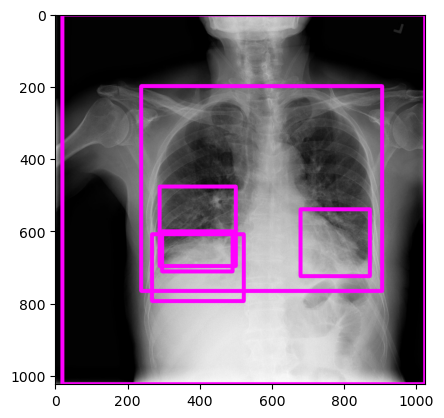

In [24]:
# Example code: Predict on one image

# Code when not using the et_prediction() function.

index = 0

# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the image
path = df_val.loc[index, 'path']
target = df_val.loc[index, 'target']
#path = images_path + fname
image = Image.open(path).convert("L") #####


# Pad the image to a square

# Convert from PIL to numpy
image = np.array(image)
# Pad to square
image = pad_image_to_square(image)
# Convert back to a PIL image
image = Image.fromarray(np.uint8(image))


# Transform the image to a torch tensor.
# Note that this 'transform' comes from torchvision.
# It's not the same as the one used in the dataloader.
# The imports above are important.
my_transform = T.Compose([T.ToTensor()])
image = my_transform(image)


# Send the image to the device
image = image.to(device)

# Load the trained model
path_model = model_path_0
model = torch.load(path_model, map_location=torch.device('cpu'))

# Put the model in eval model
model.eval()

# Send the model to the device
model.to(device)

# Predict on the image
pred = model([image])

pred_dict = process_fasterrcnn_preds(pred, THRESHOLD)

print(pred_dict)


# Load the image
path = df_val.loc[index, 'path']
fname = df_val.loc[index, 'fname']
print(fname)
image = cv2.imread(path)


# Draw true bboxes on image
# -------------------------

"""
# Get the true bboxes
df_true = df_orig[df_orig['fname'] == fname]
df_true = df_true.reset_index(drop=True)
true_bbox_list = list(df_true['bbox'])

# Draw the true bboxes on the image
for bbox_coords in true_bbox_list:

    image = draw_true_bbox_on_image(image, bbox_coords)
    
"""
    
    
# Draw pred bboxes on the image
# ------------------------------

pred_boxes = pred_dict['pred_boxes']

for i in range(0, len(pred_boxes)):
    
    bbox_coords = pred_boxes[i]

    image = draw_pred_bbox_on_image(image, bbox_coords)
    
    

print(f'Target: {target}')

plt.imshow(image)
plt.show()

In [25]:
# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

df_unq = df_val.drop_duplicates('fname')
df_unq = df_unq.reset_index(drop=True)

fin_pred_list = []

for i in tqdm(range(0, len(df_unq)), total=len(df_unq)):

    # Load the image
    path = df_unq.loc[i, 'path']
    #path = images_path + fname
    image = Image.open(path).convert("L") #####
    
    
    # Pad the image to a square
    
    # Convert from PIL to numpy
    image = np.array(image)
    # Pad to square
    image = pad_image_to_square(image)
    # Convert back to a PIL image
    image = Image.fromarray(np.uint8(image))
    

    # Transform the image to a torch tensor.
    # Note that this 'transform' comes from torchvision.
    # It's not the same as the one used in the dataloader.
    # The imports above are important.
    my_transform = T.Compose([T.ToTensor()])
    image = my_transform(image)


    # Send the image to the device
    image = image.to(device)

    # Load the trained model
    path_model = model_path_0
    model = torch.load(path_model, map_location=torch.device('cpu'))
    #model = torch.load(path_model)

    # Put the model in eval model
    model.eval()

    # Send the model to the device
    model.to(device)

    # Predict on the image
    pred = model([image])

    pred_dict = process_fasterrcnn_preds(pred, THRESHOLD)
    
    fin_pred_list.append(pred_dict)
    
    
# Add the preds to df_unq
df_unq['preds'] = fin_pred_list

df_unq.head()

100%|██████████| 4888/4888 [23:27<00:00,  3.47it/s]


,fname,image_height,image_width,bbox,target,data_source,label,path,fold,preds
0,00704310-78a8-4b38-8475-49f4573b2dbb.png,1024,1024,"{'xmin': 323, 'ymin': 577, 'width': 160, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,0.0,"{'pred_scores': [0.9999553, 0.89496076, 0.8760..."
1,010ccb9f-6d46-4380-af11-84f87397a1b8.png,1024,1024,"{'xmin': 652, 'ymin': 437, 'width': 161, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,0.0,"{'pred_scores': [0.99996495, 0.9460011, 0.8614..."
2,012a5620-d082-4bb8-9b3b-e72d8938000c.png,1024,1024,"{'xmin': 133, 'ymin': 613, 'width': 275, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,0.0,"{'pred_scores': [0.99989974, 0.95544237, 0.896..."
3,01a7353d-25bb-4ff8-916b-f50dd541dccf.png,1024,1024,"{'xmin': 214, 'ymin': 582, 'width': 239, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,0.0,"{'pred_scores': [0.99995875, 0.871344, 0.83093..."
4,01cad8d0-45cd-4603-b099-94055d322310.png,1024,1024,"{'xmin': 218, 'ymin': 667, 'width': 258, 'heig...",1,pneu_comp,Lung Opacity,../input/pneumonia-comp-proc-images/base_dir/p...,0.0,"{'pred_scores': [0.99972314, 0.9323709, 0.8977..."


## Create the binary preds

In [26]:
# Get the pred target

# Note: During training the normal images were assigned class 2. That's
# why the model predicts class 2 for normal images.
# Here we will assign class 0 to normal images. This will allow us to
# compare the preds with the target column. The target column has classes 0 and 1.

# Here we will also remove class 3 preds. Class 3 refers to the lung bboxes.

def get_binary_pred(x):
    
    
    #x = ast.literal_eval(x)
    orig_pred_labels_list = x['pred_labels']
    
    assert type(orig_pred_labels_list) == list
    
    # Remove 3 from orig_pred_labels_list.
    # Target 3 is the lungs bbox
    pred_labels_list = []
    
    for item in orig_pred_labels_list:
        if item != 3:
            pred_labels_list.append(item)
            
    
    # If no labels were predicted then
    # the image is normal i.e. class 2.
    if len(pred_labels_list) == 0:
        return 0 # change class 2 to class 0
    
    # If the model predicted only one bbox
    elif len(pred_labels_list) == 1:
        
        # If the predicted label was class 2
        if pred_labels_list[0] == 2:
            return 0 # change class 2 to class 0
        else:
            return 1
        
    # The model predicted opacity bboxes.
    # Note: If a class 2 bbox was predicted in addition to
    # class 1 bboxes, we must not draw the class 2 bbox
    # on the image when showing the user the predictions.
    else:
        return 1
    
df_unq['binary_pred'] = df_unq['preds'].apply(get_binary_pred)

#df_unq.head()

In [27]:
# Check for NaN values

nan_list = list(df_unq['binary_pred'].isnull())

df_unq['nan'] = nan_list

df_unq[df_unq['nan'] == True]

,fname,image_height,image_width,bbox,target,data_source,label,path,fold,preds,binary_pred,nan


In [28]:
df_unq['target'].value_counts()

0    2687
1    2201
Name: target, dtype: int64

In [29]:
df_unq['binary_pred'].value_counts()

1    2513
0    2375
Name: binary_pred, dtype: int64

## Conf Matrix and Classif Report

In [30]:
from sklearn.metrics import confusion_matrix
import itertools
    
# targets
y_true = list(df_unq['target'])

# get the preds as integers
y_pred = list(df_unq['binary_pred'])

# argmax returns the index of the max value in each row.
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix.
print()
print(cm)
print(CLASS_LIST)


[[2276  411]
 [  99 2102]]
['normal', 'opacity']


Confusion matrix, without normalization
[[2276  411]
 [  99 2102]]


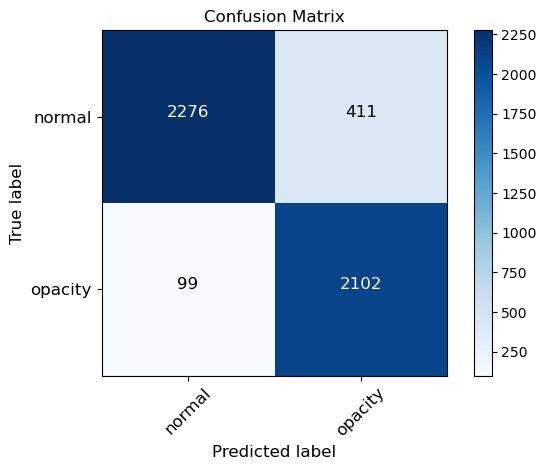

In [31]:
cm_plot_labels = CLASS_LIST

# Set the size of the plot.
#plt.figure(figsize=(10,7))

# Set the size of the text
text_size=12

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', text_size=text_size)

In [32]:
from sklearn.metrics import classification_report
    
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print()
print(report)


              precision    recall  f1-score   support

      normal       0.96      0.85      0.90      2687
     opacity       0.84      0.96      0.89      2201

    accuracy                           0.90      4888
   macro avg       0.90      0.90      0.90      4888
weighted avg       0.90      0.90      0.90      4888



In [33]:
# Create a requirements.txt file
# This is a list of all packages and their versions that were 
# used to create this solution.

!pip freeze > requirements.txt

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [34]:
!ls

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
__notebook__.ipynb  requirements.txt
